# Examen práctico 
## Parcial 1 Laboratorio de Aprendizaje Estadístico
Diego Lozoya Morales | 745345

# Paqueterías

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [96]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure(figsize=(10, 5))
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.grid()
    plt.legend()
    plt.show()

def vibariado(df, y):
    target = y.name
    num_vars = len(df.keys().drop(target))
    num_rows = (num_vars + 1) // 2 
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    axes = axes.flatten()
    
    for idx, i in enumerate(df.keys().drop(target)):
        X = df[[i]]
        model = linear_model.LinearRegression().fit(X, y)
        
        q = len(X.iloc[:, 0].unique()) if len(X.iloc[:, 0].unique()) < 5 else 10
        df[i + "_bin"] = pd.qcut(df[i], q=q, labels=False, duplicates="drop") + 1
        grouped = df.groupby(i + "_bin").mean()
        
        ax = axes[idx]
        ax.plot(grouped[i].values, grouped[target].values, color=colors[0], marker='o')
        ax.set_xlabel(f"{i} bins")
        ax.set_ylabel(target)
        ax.set_title(f"Análisis bivariado entre {i} y {target}")
        ax.grid()
        
        df.drop(columns=[i + "_bin"], inplace=True)
    
    plt.tight_layout()
    plt.show()

def comparacion(modelos, y):
     plt.figure(figsize=(10, 5))

     for i, modelo in enumerate(modelos):
          col_pred = f'predicciones_{modelo}'

          df_calibracion = pd.DataFrame({
               'predicciones': globals()[col_pred],
               'y': y
          })

          df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=10, labels=False)+1
          grouped = df_calibracion.groupby('bins').mean()
          plt.plot(grouped['predicciones'].values, grouped['y'].values, marker='o', color=colors[i], label=modelos[i])

     plt.plot(grouped['predicciones'].values, grouped['predicciones'].values, color=colors[-1], linestyle="--", label="Real", zorder=100)
     plt.xlabel("Valores predichos")
     plt.ylabel("Valores reales")
     plt.title("Comparación de modelos")
     plt.grid()
     plt.legend()
     plt.show()

def graficas_KNN(resultados, nn_opt):
     fig, axes = plt.subplots(1, 2, figsize=(15, 5))  

     axes[0].plot(resultados.nn, resultados.r2, label='real', color=colors[0], marker='o')
     axes[0].grid()
     axes[0].set_title("$R^2$ Real")
     axes[0].set_xlabel("Nearest Neighbors")
     axes[0].set_ylabel("$R^2$")

     axes[1].plot(resultados.nn, resultados.r2_train, label='train', color=colors[1], marker='o')
     axes[1].grid()
     axes[1].set_title("$R^2$ Train")
     axes[1].set_xlabel("Nearest Neighbors")
     axes[1].set_ylabel("$R^2$")

     plt.show()

     plt.figure(figsize=(15, 5))
     plt.plot(resultados.nn, resultados.r2, label='Real', color=colors[0], marker='o')
     plt.plot(resultados.nn, resultados.r2_train, label='Train', color=colors[1], marker='o')
     plt.scatter(nn_opt, max(resultados.r2), label=f'Óptimo nn = {nn_opt}', color=colors[2], s=50, zorder=3)
     plt.text(nn_opt, max(resultados.r2)-0.05, f"Máximo $R^2$", va='bottom')
     plt.grid()
     plt.legend()
     plt.title("$R^2$ Real vs Train")
     plt.xlabel("Nearest Neighbors")
     plt.ylabel("$R^2$")
     plt.show()

# Data

In [97]:
data = pd.read_csv("Data/Boston.csv")
data.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Explicación variables Dataset

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000's

## Limpieza de datos

In [98]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Variable dependiente

In [99]:
target = 'medv'
y = data[target]

# Análisis Dataset

## Correlación

<Axes: >

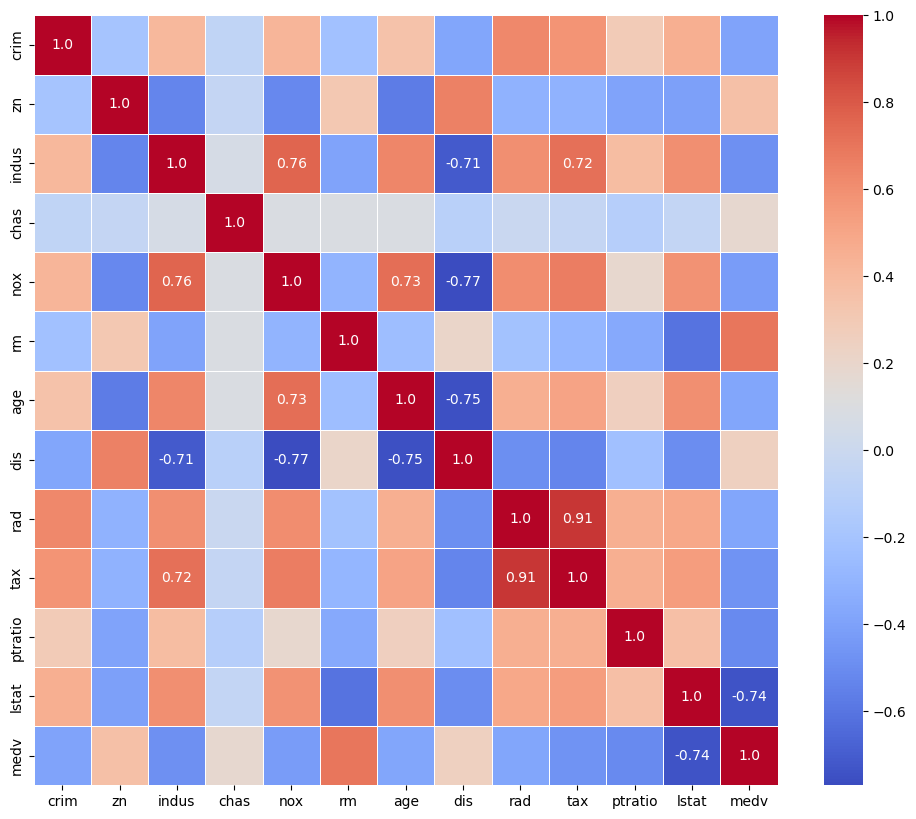

In [100]:
corr_matrix = data.corr().round(2)
mask = np.abs(corr_matrix) > 0.7
annot = np.where(mask, corr_matrix.astype(str), "")

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=annot, cmap="coolwarm", fmt="", linewidths=0.5)

In [101]:
pd.DataFrame(data.corr()[target]).sort_values(by=target, ascending=False).drop(index=target)

,medv
rm,0.695360
zn,0.360445
dis,0.249929
chas,0.175260
age,-0.376955
rad,-0.381626
crim,-0.388305
nox,-0.427321
tax,-0.468536
indus,-0.483725


## Análisis vibariado

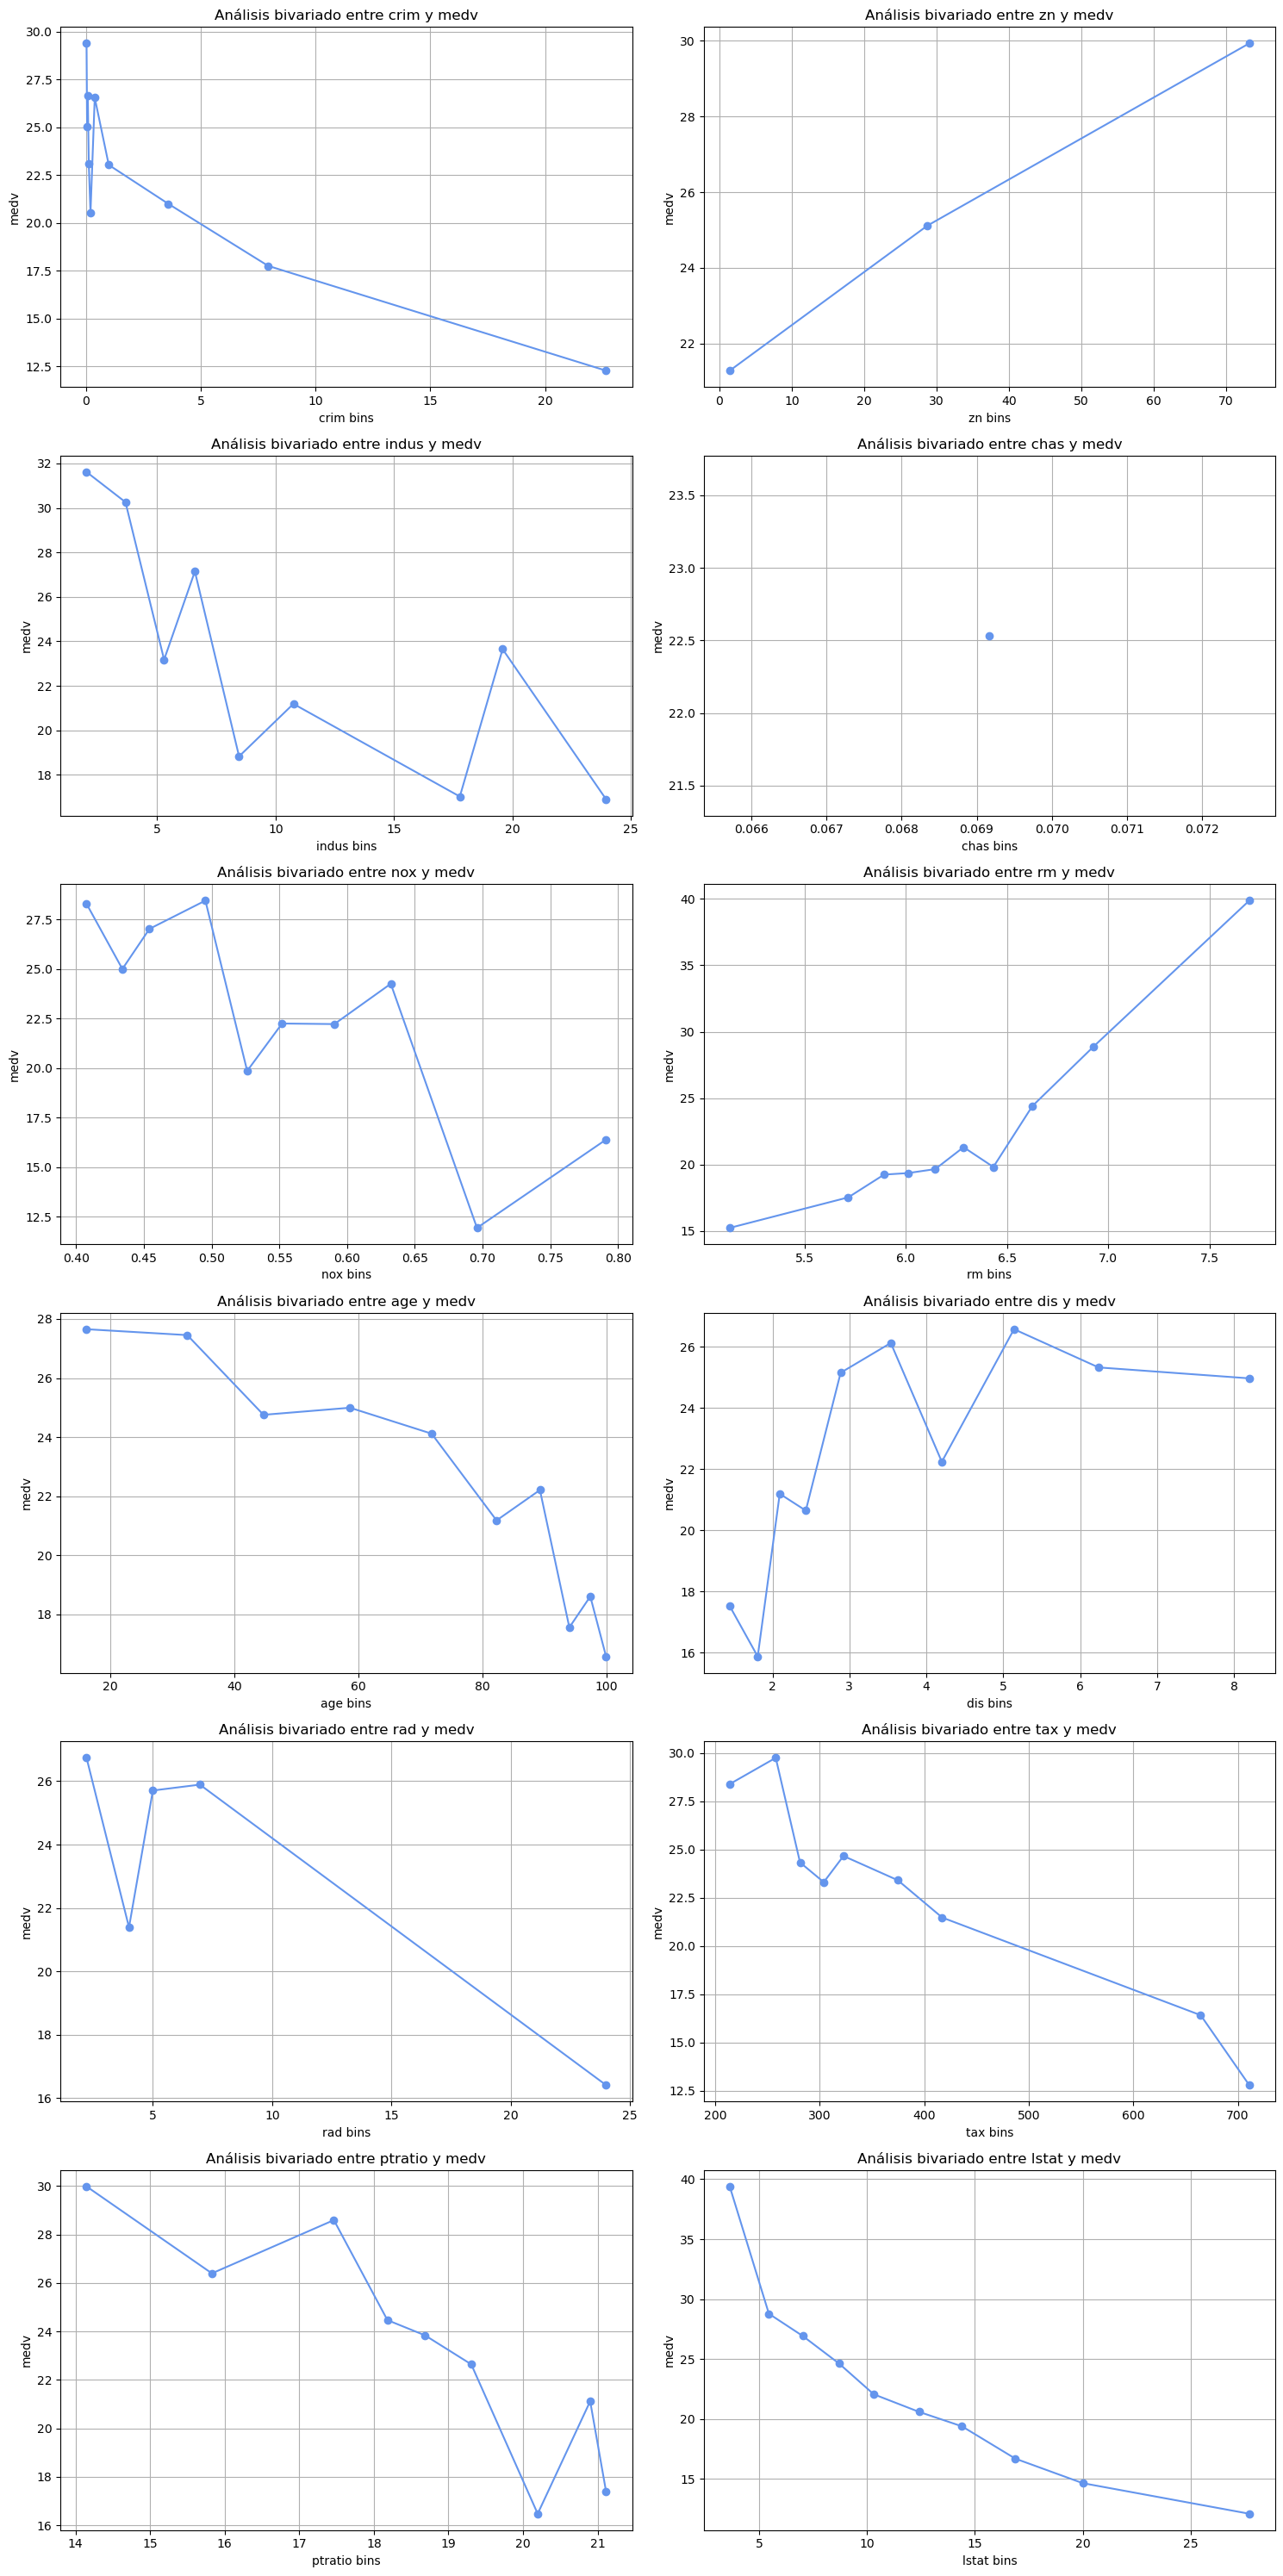

In [102]:
vibariado(data, y)

# Feature engineering

## Dummies

In [103]:
data = pd.get_dummies(data, columns=['rad'])

## Nuevas Variables
- Relación entre impuestos y accesibilidad a carreteras

In [104]:
'''# Transformaciones logarítmicas para reducir la asimetría
data['log_crim'] = np.log1p(data['crim'])
data['log_indus'] = np.log1p(data['indus'])
data['log_nox'] = np.log1p(data['nox'])
data['log_rm'] = np.log1p(data['rm'])
data['log_age'] = np.log1p(data['age'])
data['log_dis'] = np.log1p(data['dis'])
data['log_tax'] = np.log1p(data['tax'])
data['log_ptratio'] = np.log1p(data['ptratio'])
data['log_lstat'] = np.log1p(data['lstat'])

# Interacciones entre variables con relaciones no lineales
data['crim_indus'] = data['crim'] * data['indus']
data['rm_lstat'] = data['rm'] * data['lstat']
data['nox_dis'] = data['nox'] * data['dis']
data['age_lstat'] = data['age'] * data['lstat']
data['tax_rm'] = data['tax'] * data['rm']
data['ptratio_nox'] = data['ptratio'] * data['nox']
data['ptratio_dis'] = data['ptratio'] * data['dis']
data['dis_indus'] = data['dis'] * data['indus']
data['tax_indus'] = data['tax'] * data['indus']

# Transformaciones recíprocas para manejar colas largas
data['inv_crim'] = 1 / (data['crim'] + 1)
data['inv_indus'] = 1 / (data['indus'] + 1)
data['inv_nox'] = 1 / (data['nox'] + 1)
data['inv_rm'] = 1 / (data['rm'] + 1)
data['inv_age'] = 1 / (data['age'] + 1)
data['inv_dis'] = 1 / (data['dis'] + 1)
data['inv_tax'] = 1 / (data['tax'] + 1)
data['inv_ptratio'] = 1 / (data['ptratio'] + 1)
data['inv_lstat'] = 1 / (data['lstat'] + 1)

# Creación de combinaciones cuadráticas
data['crim2'] = data['crim'] ** 2
data['indus2'] = data['indus'] ** 2
data['nox2'] = data['nox'] ** 2
data['rm2'] = data['rm'] ** 2
data['age2'] = data['age'] ** 2
data['dis2'] = data['dis'] ** 2
data['tax2'] = data['tax'] ** 2
data['ptratio2'] = data['ptratio'] ** 2
data['lstat2'] = data['lstat'] ** 2

# Interacciones entre transformaciones
data['log_crim_lstat'] = data['log_crim'] * data['log_lstat']
data['log_rm_dis'] = data['log_rm'] * data['log_dis']
data['inv_nox_age'] = data['inv_nox'] * data['inv_age']
data['ptratio_dis2'] = data['ptratio'] * data['dis2']
data['tax_rm_inv_age'] = data['tax_rm'] / (data['inv_age'] + 1)

data = data.drop(columns=data.iloc[:,:11].keys())'''

"# Transformaciones logarítmicas para reducir la asimetría\ndata['log_crim'] = np.log1p(data['crim'])\ndata['log_indus'] = np.log1p(data['indus'])\ndata['log_nox'] = np.log1p(data['nox'])\ndata['log_rm'] = np.log1p(data['rm'])\ndata['log_age'] = np.log1p(data['age'])\ndata['log_dis'] = np.log1p(data['dis'])\ndata['log_tax'] = np.log1p(data['tax'])\ndata['log_ptratio'] = np.log1p(data['ptratio'])\ndata['log_lstat'] = np.log1p(data['lstat'])\n\n# Interacciones entre variables con relaciones no lineales\ndata['crim_indus'] = data['crim'] * data['indus']\ndata['rm_lstat'] = data['rm'] * data['lstat']\ndata['nox_dis'] = data['nox'] * data['dis']\ndata['age_lstat'] = data['age'] * data['lstat']\ndata['tax_rm'] = data['tax'] * data['rm']\ndata['ptratio_nox'] = data['ptratio'] * data['nox']\ndata['ptratio_dis'] = data['ptratio'] * data['dis']\ndata['dis_indus'] = data['dis'] * data['indus']\ndata['tax_indus'] = data['tax'] * data['indus']\n\n# Transformaciones recíprocas para manejar colas lar

In [105]:
'''for col in data.iloc[:,12:].columns:  
    data[f'tax_{col}'] = data['tax'] * data[col]

data['nox_indus'] = data['nox'] / (data['indus'] + 1)
data['age_indus'] = data['age'] / data['indus']
data['age_nox'] = data['age'] / (data['nox'] + 1)
data['dis_zn'] = data['dis'] / (data['zn'] + 1)
data['dis_indus'] = data['dis'] / (data['indus'] + 1)
data['dis_nox'] = data['dis'] / (data['nox'] + 1)
data['dis_age'] = data['dis'] / (data['age'] + 1)
data['tax_indus'] = data['tax'] / (data['indus'] + 1)
data['tax_nox'] = data['tax'] / (data['nox'] + 1)
data['lstat_rm'] = data['lstat'] / data['rm']
#data[''] = data[''] / data['']'''

data['crim_indus'] = data['crim'] / (data['indus'] + 1)
data['crim_lstat'] = data['crim'] / (data['lstat'] + 1)
data['rm_lstat'] = data['rm'] / (data['lstat'] + 1)
data['nox_indus'] = data['nox'] / (data['indus'] + 1)
data['nox_dis'] = data['nox'] / (data['dis'] + 1)
data['age_lstat'] = data['age'] / (data['lstat'] + 1)
data['tax_rm'] = data['tax'] / (data['rm'] + 1)
data['tax_lstat'] = data['tax'] / (data['lstat'] + 1)
data['ptratio_rm'] = data['ptratio'] / (data['rm'] + 1)
data['ptratio_nox'] = data['ptratio'] / (data['nox'] + 1)
data['ptratio_dis'] = data['ptratio'] / (data['dis'] + 1)
data['nox_age'] = data['nox'] / (data['age'] + 1)
data['dis_indus'] = data['dis'] / (data['indus'] + 1)
data['tax_indus'] = data['tax'] / (data['indus'] + 1)

## Transformaciones

- Logaritmo de la tasa de crimen per capita por ciudad
- Logaritmo de la concentración de óxido nitrico
- Cuadrado de número de cuartos promedio por vivienda
- Raíz de la distancia ponderada de 5 centros de empleo en Boston
- Logaritmo del valor total de la propiedad por la tasa de impuestos por $10,000

In [106]:
'''data['log_crim'] = np.log(data['crim'])
data['log_nox'] = np.log(data['nox'])
data['rm_2'] = data['rm'] ** 2
data['sqrt_dis'] = np.sqrt(data['dis'])
data['log_tax'] = np.log(data['tax'])'''

data = data.drop(columns=data.iloc[:,:11].keys())

# Significancia de variables

In [107]:
controls = data.keys().drop(target)

result = smf.ols('medv ~ ' + '+'.join(controls), data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,35.6787,3.483,10.244,0.000,28.835,42.522
rad_1[T.True],1.0185,0.937,1.088,0.277,-0.822,2.859
rad_2[T.True],3.1092,0.888,3.503,0.001,1.365,4.853
rad_3[T.True],4.9967,0.814,6.135,0.000,3.396,6.597
rad_4[T.True],3.8427,0.588,6.532,0.000,2.687,4.999
rad_5[T.True],3.7580,0.533,7.047,0.000,2.710,4.806
rad_6[T.True],3.2403,0.806,4.018,0.000,1.656,4.825
rad_7[T.True],5.5523,1.082,5.133,0.000,3.427,7.678
rad_8[T.True],6.1863,0.913,6.779,0.000,4.393,7.979
rad_24[T.True],3.9746,1.264,3.146,0.002,1.492,6.457


# Preparación de datos

## Cross validation

In [108]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scaler

In [109]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regresión lineal múltiple

## Modelo normal

In [110]:
model = linear_model.LinearRegression().fit(X_train_scaled, y_train)
predicciones_RLM = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.7764
MSE: 16.6622

Intercepto del modelo: 23.01
Coeficientes del modelo:


,names,coeficientes
0,rad_1,-1.113923e+13
1,rad_2,-1.246261e+13
2,rad_3,-1.492442e+13
3,rad_4,-2.178448e+13
4,rad_5,-2.342790e+13
5,rad_6,-1.246261e+13
6,rad_7,-1.040060e+13
7,rad_8,-1.246261e+13
8,rad_24,-2.407869e+13
9,crim_indus,-3.575820e+00


### Calibración

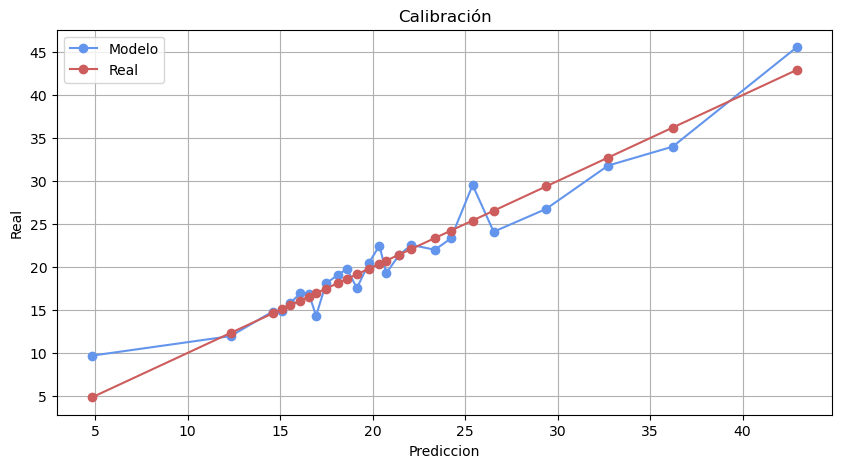

In [111]:
calibracion(predicciones_RLM, y_test, 25)

## Regularización Ridge

In [112]:
model = linear_model.Ridge().fit(X_train_scaled, y_train)
predicciones_RLM_ridge = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM_ridge)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.7779
MSE: 16.5504

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,rad_1,-0.456888
1,rad_2,-0.045419
2,rad_3,0.259325
3,rad_4,-0.005391
4,rad_5,0.032287
5,rad_6,-0.105032
6,rad_7,0.275337
7,rad_8,0.457661
8,rad_24,-0.253843
9,crim_indus,-3.419327


### Calibración

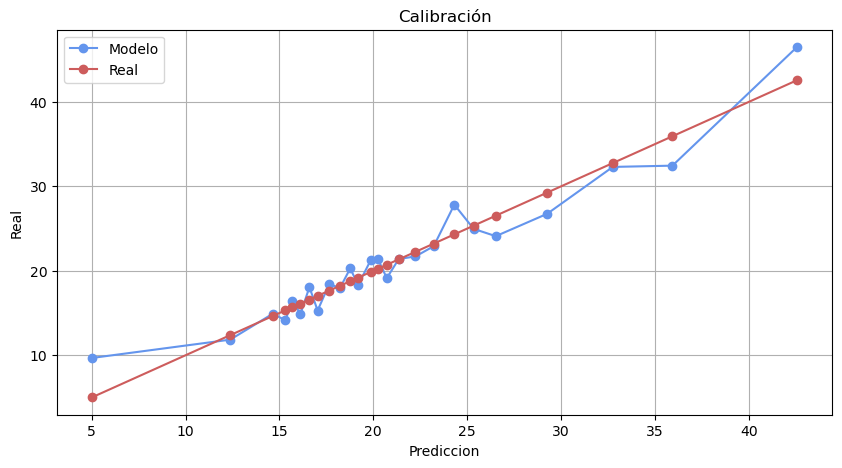

In [113]:
calibracion(predicciones_RLM_ridge, y_test, 25)

## Regularización Lasso

In [114]:
model = linear_model.Lasso().fit(X_train_scaled, y_train)
predicciones_RLM_lasso = model.predict(X_test_scaled)

r2 = r2_score(y_true=y_test, y_pred=predicciones_RLM_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RLM_lasso)
print(f"MSE: {mse:,.4f}")

coeficientes = pd.DataFrame({
     'names': X.keys(),
     'coeficientes': model.coef_
})

print()
print(f"Intercepto del modelo: {model.intercept_:,.2f}\nCoeficientes del modelo:")
display(coeficientes)

R² Score: 0.7140
MSE: 21.3081

Intercepto del modelo: 23.02
Coeficientes del modelo:


,names,coeficientes
0,rad_1,-0.000000
1,rad_2,0.000000
2,rad_3,0.000000
3,rad_4,-0.000000
4,rad_5,0.000000
5,rad_6,-0.000000
6,rad_7,0.000000
7,rad_8,0.000000
8,rad_24,-0.000000
9,crim_indus,-0.446489


### Calibración

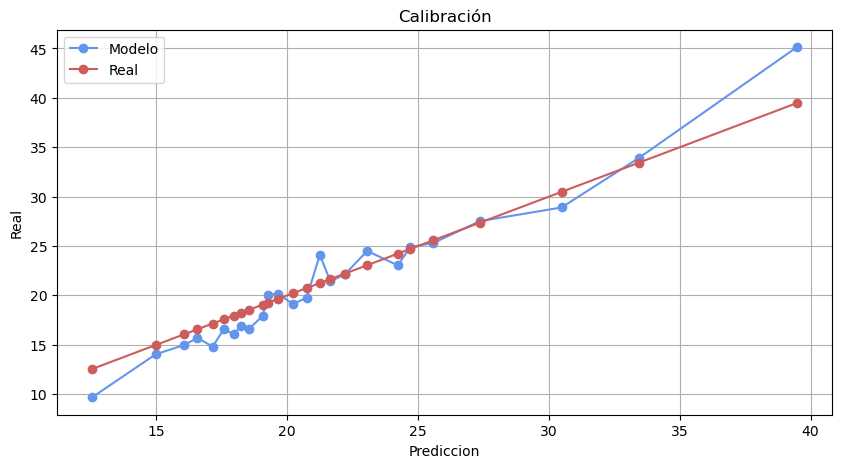

In [115]:
calibracion(predicciones_RLM_lasso, y_test, 25)

## Comparación modelos

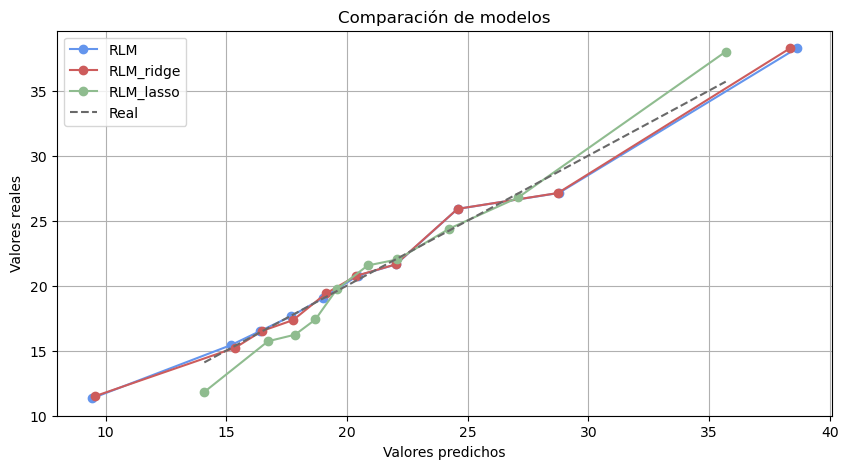

In [116]:
modelos = ['RLM', 'RLM_ridge', 'RLM_lasso']

comparacion(modelos, y_test)

# Regresión polinomial

## Grado 2

In [117]:
degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [118]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly2 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2)
print(f"MSE: {mse:,.4f}")

R² Score: -533,946,742,969,966.8125
MSE: 39,786,024,687,072,544.0000


#### Calibración

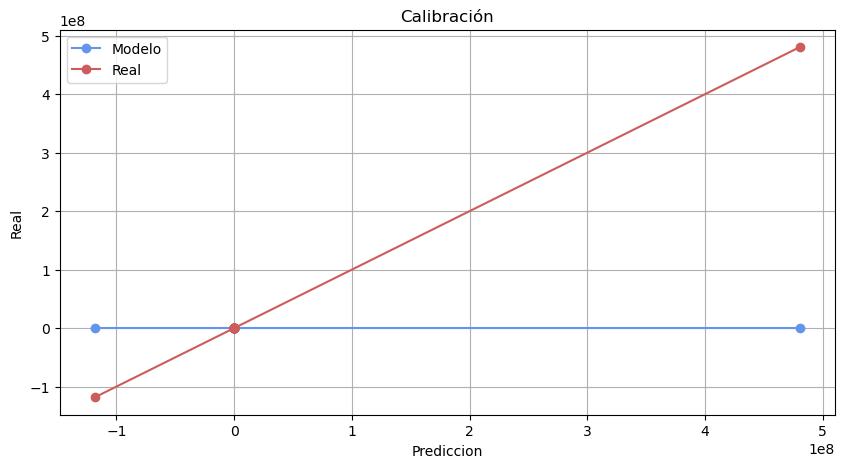

In [119]:
calibracion(predicciones_poly2, y_test, 25)

### Regularización Ridge

In [120]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly2_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7337
MSE: 19.8443


#### Calibración

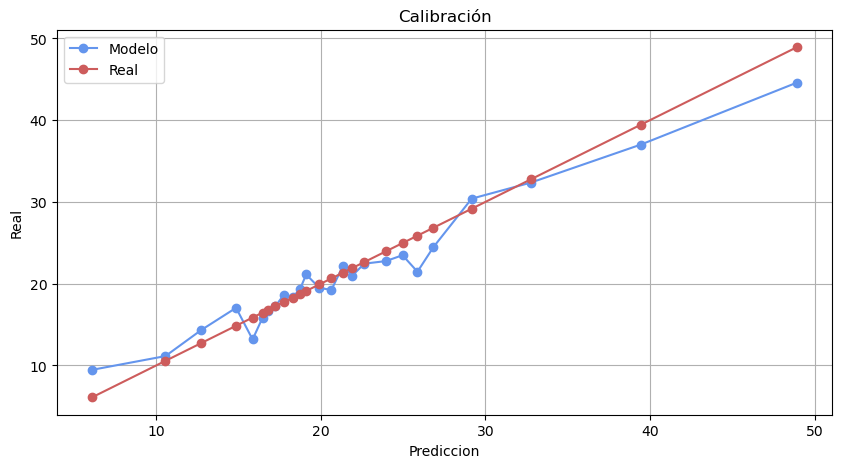

In [121]:
calibracion(predicciones_poly2_ridge, y_test, 25)

### Regularización Lasso

In [122]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly2_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly2_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly2_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7647
MSE: 17.5359


#### Calibración

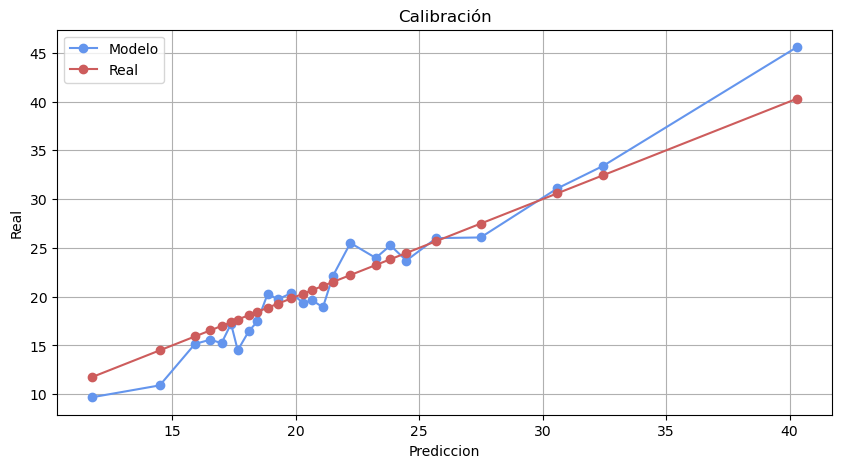

In [123]:
calibracion(predicciones_poly2_lasso, y_test, 25)

### Comparación modelos

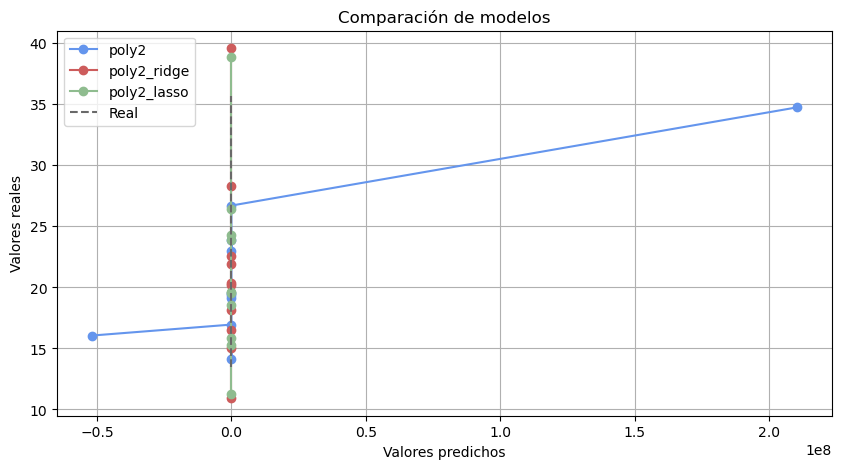

In [124]:
modelos = ['poly2', 'poly2_ridge', 'poly2_lasso']

comparacion(modelos, y_test)

## Grado 3

In [125]:
degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train_scaled)
X_poly_test = poly_features.fit_transform(X_test_scaled)

### Modelo Normal

In [126]:
model = linear_model.LinearRegression().fit(X_poly_train, y_train)
predicciones_poly3 = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3)
print(f"MSE: {mse:,.4f}")

R² Score: -2,396.5602
MSE: 178,649.6344


#### Calibración

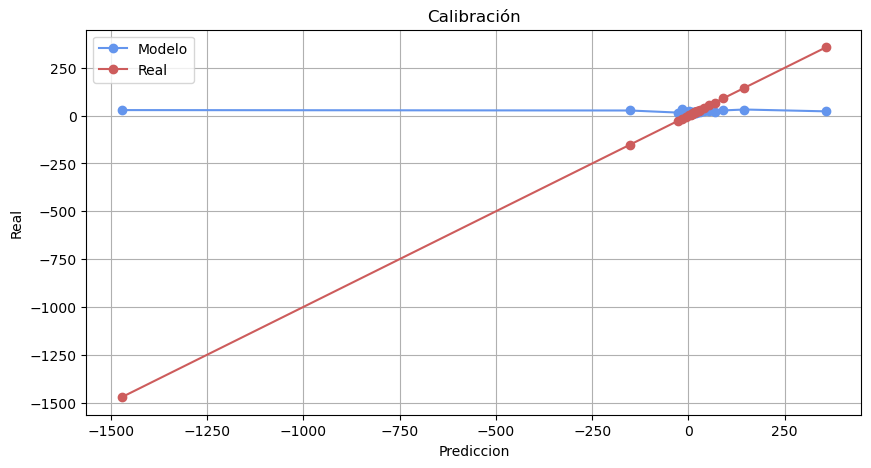

In [127]:
calibracion(predicciones_poly3, y_test, 25)

### Regularización Ridge

In [128]:
model = linear_model.Ridge().fit(X_poly_train, y_train)
predicciones_poly3_ridge = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3_ridge)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3_ridge)
print(f"MSE: {mse:,.4f}")

R² Score: -2.9125
MSE: 291.5349


#### Calibración

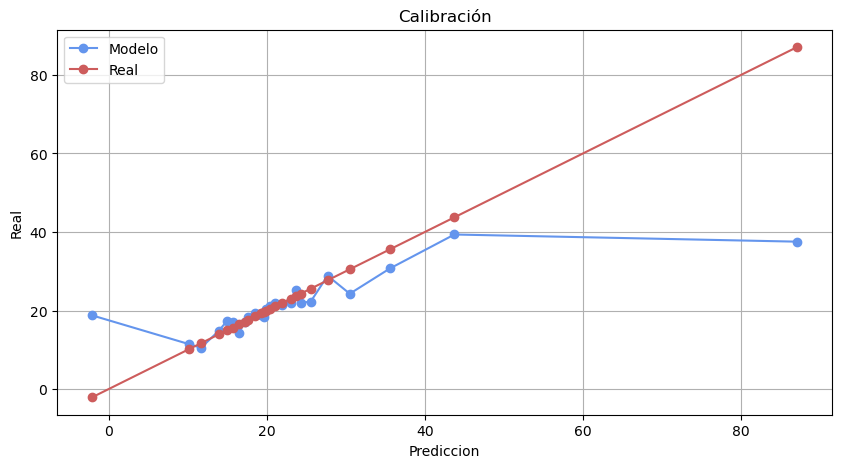

In [129]:
calibracion(predicciones_poly3_ridge, y_test, 25)

### Regularización Lasso

In [130]:
model = linear_model.Lasso().fit(X_poly_train, y_train)
predicciones_poly3_lasso = model.predict(X_poly_test)

r2 = r2_score(y_true=y_test, y_pred=predicciones_poly3_lasso)
print(f"R² Score: {r2:,.4f}")

mse = mean_squared_error(y_true=y_test, y_pred=predicciones_poly3_lasso)
print(f"MSE: {mse:,.4f}")

R² Score: 0.7556
MSE: 18.2129


#### Calibración

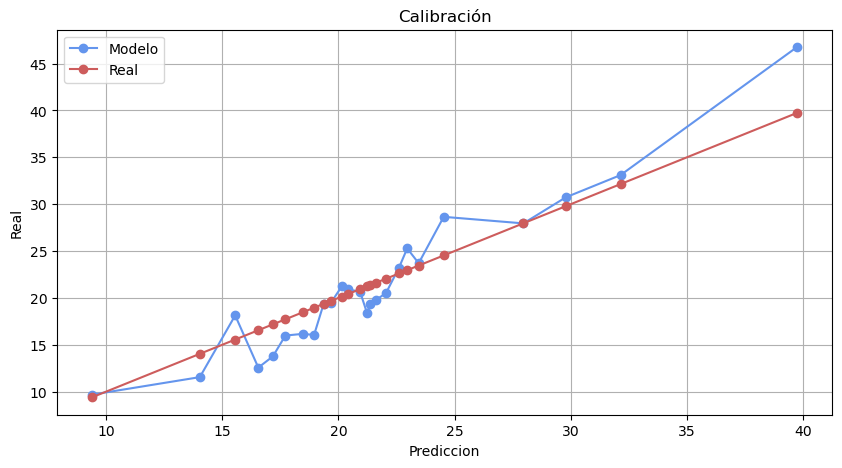

In [131]:
calibracion(predicciones_poly3_lasso, y_test, 25)

### Comparación modelos

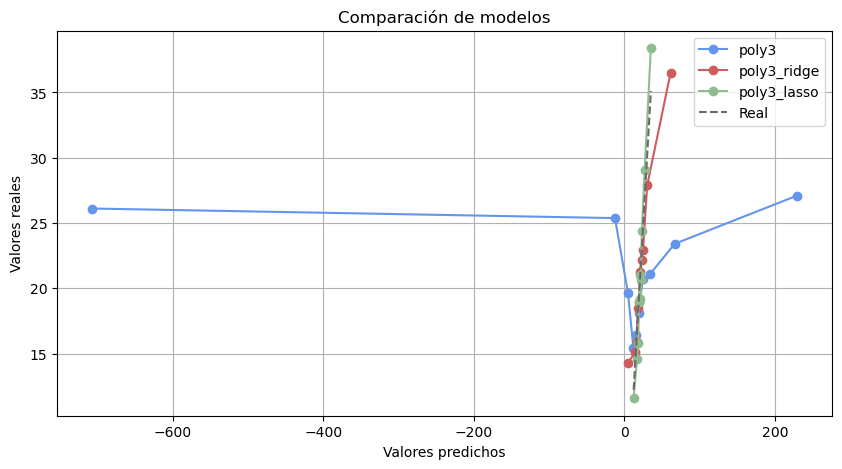

In [132]:
modelos = ['poly3', 'poly3_ridge', 'poly3_lasso']

comparacion(modelos, y_test)

# KNN

## Aproximación gráfica

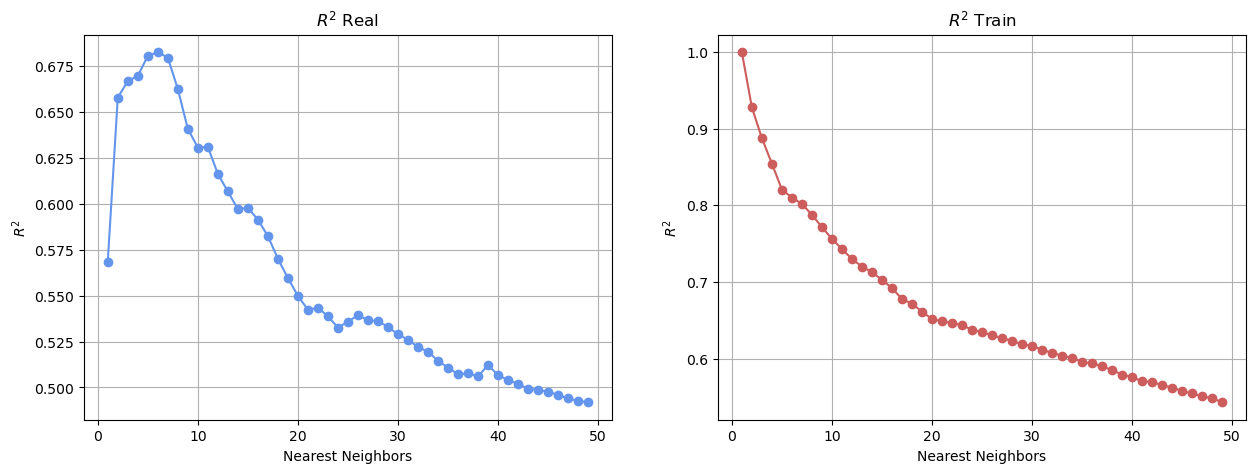

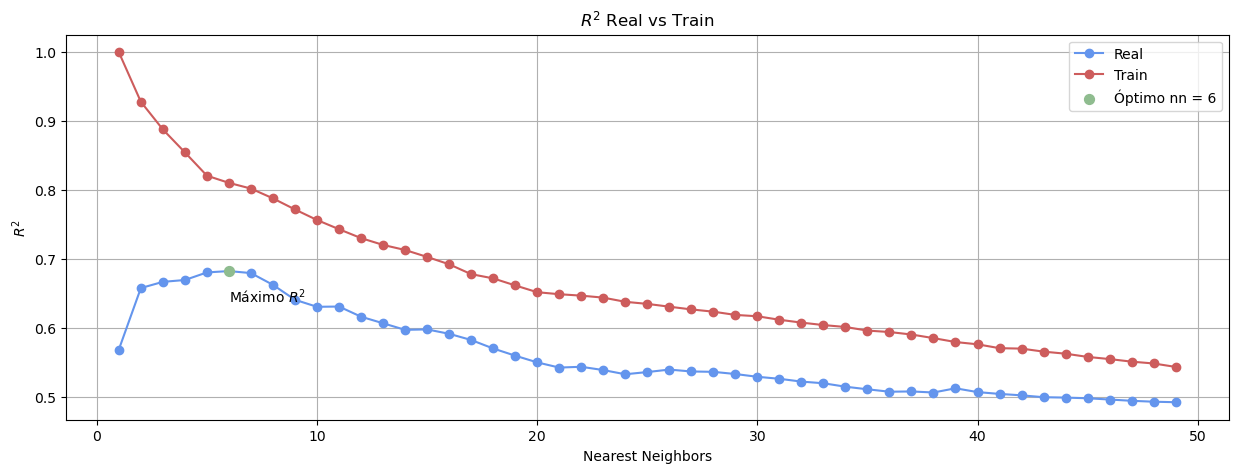

In [133]:
nn = []
r2 = []
r2_train = []
for i in range(1, 50):
    
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)

    r2.append(r2_score(y_true=y_test, y_pred=predicciones))
    nn.append(i)

    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_true=y_train, y_pred=predicciones_train))

resultados = pd.DataFrame({'r2': r2, 'nn': nn, 'r2_train': r2_train})

nn_opt = resultados[resultados.r2 == max(resultados.r2)].nn.values[0]

graficas_KNN(resultados, nn_opt)

## Prueba y error

In [134]:
model = KNeighborsRegressor(n_neighbors=nn_opt-1 if nn_opt > 1 else nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr_minus = r2_score(y_true=y_test, y_pred=predicciones)

model = KNeighborsRegressor(n_neighbors=nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr = r2_score(y_true=y_test, y_pred=predicciones)

model = KNeighborsRegressor(n_neighbors=nn_opt+1).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr_plus = r2_score(y_true=y_test, y_pred=predicciones)

print(f"R2 con {nn_opt-1 if nn_opt > 1 else nn_opt} neighbors: {nn_opt_nbr_minus:.4f} \nR2 con {nn_opt} neighbors: {nn_opt_nbr:.4f} \nR2 con {nn_opt+1} neighbors: {nn_opt_nbr_plus:.4f}")

R2 con 5 neighbors: 0.6804 
R2 con 6 neighbors: 0.6824 
R2 con 7 neighbors: 0.6794


# Conclusiones generales